# Word2vec model
This model uses a pretrained word2vec to vectorize the paragraphs, with weights based on a TF-IDF vectorizer. This is evaluated with a simple linear SVM.

A pretrained word2vec can be found on [this github repo](https://github.com/3Top/word2vec-api).

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
df = pd.read_csv("../../data/ad_hominem/ad_hominems_cleaned_Murilo.csv", sep=",", index_col=0, header=0, names=["body", "isAdHominem"])

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split( df, test_size=0.3, random_state=3)

print("In total, the train contains", sum(train["isAdHominem"] == True), "ad hominems")
print("In total, the test contains", sum(test["isAdHominem"] == True), "ad hominems")

In total, the train contains 1738 ad hominems
In total, the test contains 759 ad hominems


In [17]:
features=1000

In [23]:
print("Starting TF-IDF vectorizer")
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer( ngram_range = (1, 1), max_features=features)
v.fit(train['body'].values.astype('U'))
x_train = v.transform(train['body'].values.astype('U'))
x_test = v.transform(test['body'].values.astype('U'))

Starting TF-IDF vectorizer


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
df.head()

,body,isAdHominem
0,What makes corporations different in this case...,0
1,I'm sorry if your smugness gets in the way. Li...,1
2,"Basically to believe a patriarchy exists, you ...",0
3,The punishment for heresy was being burned at ...,0
4,No it doesn't. Sex is defined by DNA. DNA cann...,0


In [21]:
print("importing word2vec")
wv_from_bin = KeyedVectors.load_word2vec_format(datapath("/Users/pieterdelobelle/Downloads/GoogleNews-vectors-negative300.bin.gz"), binary=True)  # C binary format
print("imported word2vec")

importing word2vec


KeyboardInterrupt: 

In [24]:
wordvecs = np.zeros( (len(v.vocabulary_), len(wv_from_bin["test"])))
for i,k in enumerate(v.vocabulary_):
    if k in wv_from_bin:
        wordvecs[i] = wv_from_bin[k]

In [11]:
def combineData( dataset ):
    train_w2v = np.zeros( (dataset.shape[0], len(v.vocabulary_), len(wv_from_bin["test"])))
    for i in range(0,dataset.shape[0]):
        if (100* i / dataset.shape[0] % 10 == 0):
            print("{} of {} ({} %)\r".format(i, dataset.shape[0], 100* i / dataset.shape[0]))
    
        train_w2v[i] = np.multiply(wordvecs.T,x_train[i,:].toarray().flatten()).T
    return train_w2v

In [25]:
test_x = combineData(x_train)

0 of 20505 (0.0 %)
4101 of 20505 (20.0 %)
8202 of 20505 (40.0 %)
12303 of 20505 (60.0 %)
16404 of 20505 (80.0 %)


In [26]:
test_y = combineData(x_test)

0 of 8789 (0.0 %)


In [27]:
print("fitting classifier")
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(test_x.reshape(test_x.shape[0],-1), train["isAdHominem"])
print("finished fitting " + LinearSVC.__name__ )

fitting classifier
finished fitting LinearSVC


In [28]:
predicted = clf.predict(test_y.reshape(test_y.shape[0],-1))

Confusion matrix, without normalization
[[7824  206]
 [ 736   23]]
Normalized confusion matrix
[[0.97 0.03]
 [0.97 0.03]]


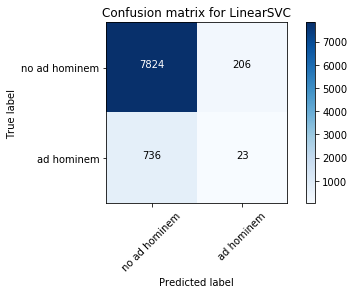

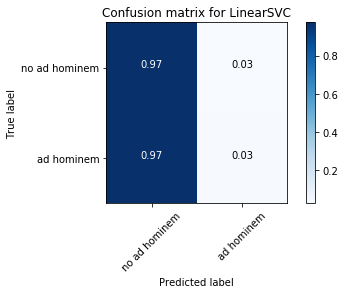

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test["isAdHominem"], predicted)

np.set_printoptions(precision=2)

title="Confusion matrix for " + LinearSVC.__name__

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["no ad hominem", "ad hominem"],normalize=False, 
                      title=title)

#print('plots exported.png')
#fig.savefig("plt_not_normalized.png")

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["no ad hominem", "ad hominem"],normalize=True, 
                      title=title)
#fig.savefig("plt_normalized.png")